In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
data = pd.read_csv('Downloads/fer2013/fer2013.csv')

In [4]:
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
data['pixels'] = data['pixels'].apply(lambda x: x.reshape(48, 48, 1))

In [6]:
X = np.array(data['pixels'].tolist())
y = pd.get_dummies(data['emotion']).values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=64)
test_generator = datagen.flow(X_test, y_test, batch_size=64)

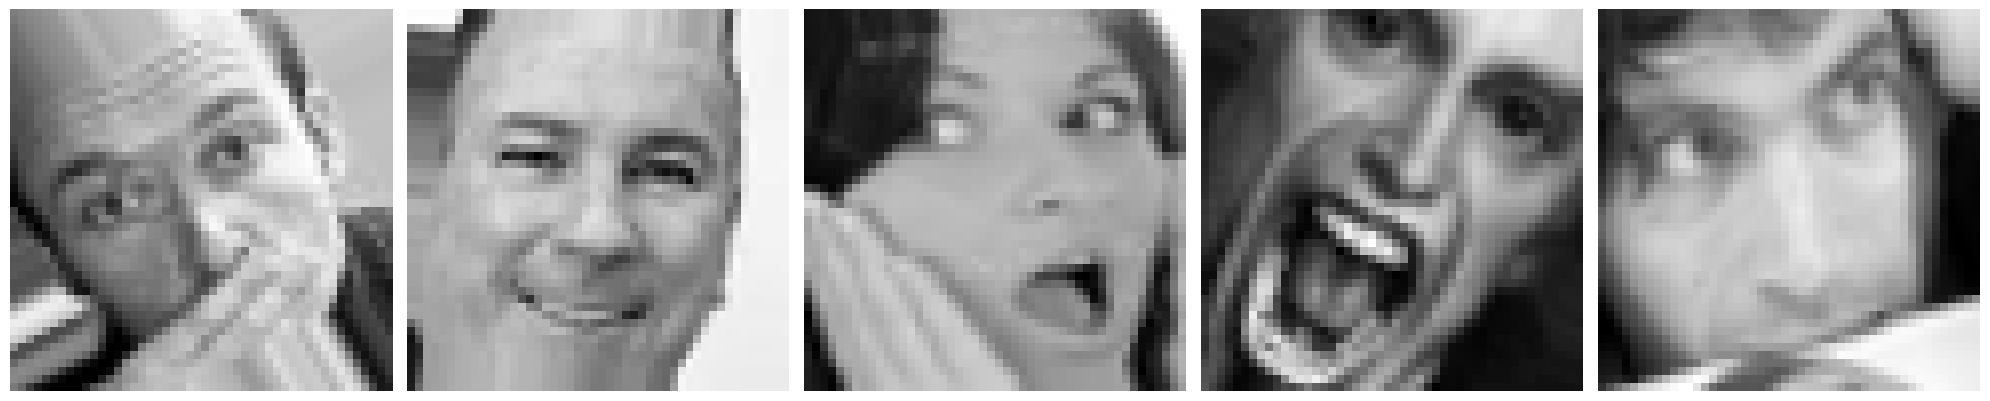

In [27]:
def plot_sample_images(generator):
    images, labels = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.reshape(48, 48), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)

In [29]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 619,015 (2.36 MB)

 Trainable params: 619,015 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=75,
    steps_per_epoch=len(X_train) // 64,
    validation_steps=len(X_test) // 64
)

Epoch 1/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 86s 177ms/step - accuracy: 0.2420 - loss: 1.8303 - val_accuracy: 0.2877 - val_loss: 1.7363
Epoch 2/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.2344 - loss: 1.8409 - val_accuracy: 0.6000 - val_loss: 1.4795
Epoch 3/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 79s 175ms/step - accuracy: 0.2832 - loss: 1.7488 - val_accuracy: 0.3359 - val_loss: 1.6676
Epoch 4/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - accuracy: 0.3125 - loss: 1.7569 - val_accuracy: 0.5000 - val_loss: 1.5082
Epoch 5/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 79s 175ms/step - accuracy: 0.3403 - loss: 1.6664 - val_accuracy: 0.3908 - val_loss: 1.5507
Epoch 6/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - accuracy: 0.3594 - loss: 1.7452 - val_accuracy: 0.5000 - val_loss: 1.5702
Epoch 7/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 79s 176ms/step - accuracy: 0.3769 - loss: 1.5791 - val_accuracy: 0.4153 - val_loss: 1.4871
Epoch 8/75
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - accuracy: 0.3906 - loss: 1.585

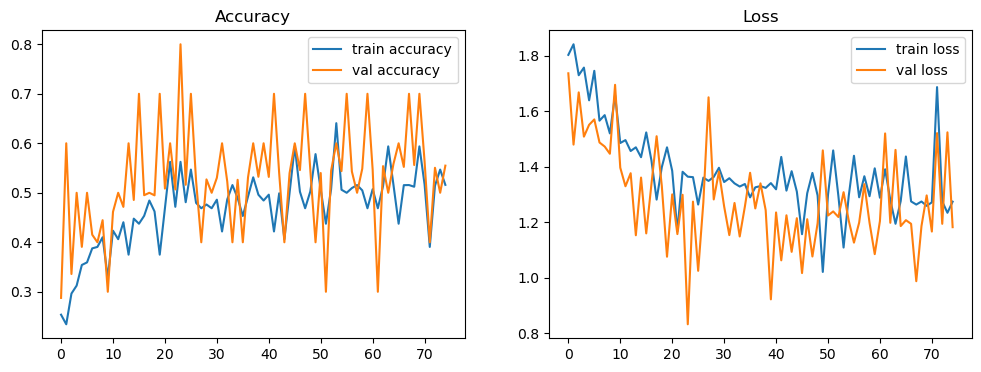

In [33]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

In [35]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
              precision    recall  f1-score   support

           0       0.21      0.17      0.19       985
           1       0.00      0.00      0.00       102
           2       0.16      0.86      0.27      1043
           3       0.58      0.11      0.19      1765
           4       0.42      0.02      0.03      1210
           5       0.33      0.01      0.01       795
           6       0.42      0.09      0.15      1278

    accuracy                           0.19      7178
   macro avg       0.30      0.18      0.12      7178
weighted avg       0.37      0.19      0.14      7178



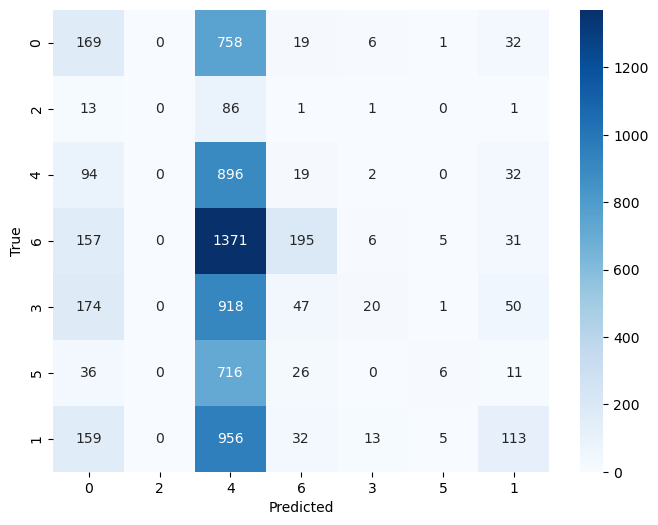

In [43]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data['emotion'].unique(), yticklabels=data['emotion'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [49]:
model.save('C:\project\Facial Emotion Detection\Emotion_detection_model[1].keras')